In [1]:
import os
os.chdir('..')
from comet_ml import Experiment, OfflineExperiment

In [2]:

from typing import Tuple, List
import logging

import numpy as np
import syft as sy
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from syftutils.datasets import get_dataset_items_at

from FFL.TorchFederatedLearner import TorchFederatedLearner, TorchFederatedLearnerConfig


class TorchFederatedLearnerMNISTConfig(TorchFederatedLearnerConfig):
    IS_IID_DATA: bool = True  # If true, the data is split random amongs clients. If false, the client have different digits.


class TorchFederatedLearnerMNIST(TorchFederatedLearner):
    def __init__(
        self, experiment: Experiment, config: TorchFederatedLearnerMNISTConfig
    ) -> None:
        """Initialises the training.

        Arguments:
            experiment {Experiment} -- Comet.ml experiment object for online logging.
            config {TorchFederatedLearnerMNISTConfig} -- Training configuration description.
        """
        super().__init__(experiment, config)
        self.config = config  # Purly to help intellisense

    def load_data(self) -> Tuple[List[th.utils.data.DataLoader], th.utils.data.DataLoader]:
        logging.info("MNIST data loading ...")
        minist_train_ds, mnist_test_ds = self.__get_mnist()
        logging.info("MNIST data loaded.")

        logging.info("Data distributing ...")
        n_training_samples = len(minist_train_ds)
        logging.info("Number of training samples: {n_training_samples}")
        if self.config.IS_IID_DATA:
            indices = np.arange(n_training_samples).reshape(self.config.N_CLIENTS, -1)
            indices = indices.tolist()
            # federated_train_dataset = minist_train_ds.federate(
            #     self.clients
            # )  # TODO HARD get list of index samples instead
        else:
            indices = self.__distribute_data_non_IID(
                minist_train_ds
            )

        # TODO HARD use list of DataLoader and indices with sampler
        train_loader_list = []
        for idx in indices:
            sampler = th.utils.data.sampler.SubsetRandomSampler(idx)
            loader = th.utils.data.DataLoader(
                dataset=minist_train_ds,
                batch_size=self.config.BATCH_SIZE,
                num_workers=self.config.DL_N_WORKER,
                sampler=sampler,
            )
            train_loader_list.append(loader)
        # federated_train_loader = sy.FederatedDataLoader(
        #     federated_train_dataset,
        #     batch_size=self.config.BATCH_SIZE,
        #     shuffle=True,
        #     num_workers=self.config.DL_N_WORKER,
        #     pin_memory=True,
        # )
        logging.info("Data distributed.")

        test_loader = th.utils.data.DataLoader(
            mnist_test_ds,
            batch_size=64,
            shuffle=True,
            num_workers=self.config.DL_N_WORKER,
        )

        return train_loader_list, test_loader

    def __get_mnist(self):
        minist_train_ds = datasets.MNIST(
            "../data",
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        )
        mnist_test_ds = datasets.MNIST(
            "../data",
            train=False,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        )
        return minist_train_ds, mnist_test_ds

    def __distribute_data_non_IID(self, minist_train_ds):
        digit_sort_idx = np.concatenate(
            [np.where(minist_train_ds.targets == i)[0] for i in range(10)]
        )
        digit_sort_idx = digit_sort_idx.reshape(2 * self.config.N_CLIENTS, -1)
        np.random.shuffle(digit_sort_idx)
        indices = [
            digit_sort_idx[i : i + 2,].flatten()
            for i in range(0, 2 * self.config.N_CLIENTS, 2)
        ]
        return indices
        # TODO return idices and remove the rest
        # dss = []
        # for idx, c in zip(indices, self.clients):
        #     data, target = get_dataset_items_at(minist_train_ds, idx)
        #     dss.append(sy.BaseDataset(data.send(c), target.send(c)))

        # federated_train_dataset = sy.FederatedDataset(dss)
        # return federated_train_dataset

    def build_model(self) -> nn.Module:
        return Net()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 64, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [27]:
lr = TorchFederatedLearnerMNIST(OfflineExperiment(offline_directory='./tmp'), TorchFederatedLearnerMNISTConfig(IS_IID_DATA=True))

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01 [15]       : (1.0, 40.0)
COMET INFO:     sys.cpu.percent.02 [15]       : (1.6, 23.8)
COMET INFO:     sys.cpu.percent.03 [15]       : (1.5, 26.9)
COMET INFO:     sys.cpu.percent.04 [15]       : (1.0, 25.4)
COMET INFO:     sys.cpu.percent.avg [15]      : (2.375, 29.025)
COMET INFO:     sys.gpu.0.free_memory [12]    : (4238999552.0, 4238999552.0)
COMET INFO:     sys.gpu.0.gpu_utilization [12]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (4238999552.0, 4238999552.0)
COMET INFO:     sys.gpu.0.used_memory [12]    : (0.0, 0.0)
COMET INFO:     sys.load.avg [15]             : (0.03, 0.97)
COMET INFO:     sys.ram.total [15]            : (8326709248.0, 8326709248.0)
COMET INFO:     sys.ram.used [15]             : (1869348864.0, 2014724096.0

In [28]:
tr, te = lr.load_data()

tensor(4)


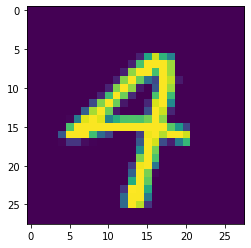

In [29]:
import matplotlib.pyplot as plt
data, target = next(iter(tr[1]))
plt.imshow(data[0, 0, ])
print(target[0])

In [40]:
for f_ in list(range(10)):
    if f_ not in target.numpy().flatten().tolist():
        print(f_)

In [41]:
sum([len(d) for d in tr]) * 64

60032

In [8]:
indices = np.arange(60000).reshape(100, -1)
indices = indices.tolist()

array([[    0,     1,     2, ...,   597,   598,   599],
       [  600,   601,   602, ...,  1197,  1198,  1199],
       [ 1200,  1201,  1202, ...,  1797,  1798,  1799],
       ...,
       [58200, 58201, 58202, ..., 58797, 58798, 58799],
       [58800, 58801, 58802, ..., 59397, 59398, 59399],
       [59400, 59401, 59402, ..., 59997, 59998, 59999]])

In [25]:
%%time
l = indices.tolist()

CPU times: user 0 ns, sys: 2.34 ms, total: 2.34 ms
Wall time: 2.34 ms


In [88]:
ds = datasets.MNIST(
            "../data",
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        )
ds.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

tensor([5, 0, 4,  ..., 5, 6, 8])